<a href="https://colab.research.google.com/github/SevioStanton/Spoon-Knife/blob/master/Battlezone_DeepQ_avoidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dependencies**

In [56]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os # for creating directories

#for rendering in colab
import glob
from IPython.display import HTML
from gym.wrappers import Monitor
import io
import base64
from IPython import display as ipythondisplay

**Setting up Rendering Process**

In [42]:
#pip installs for rendering
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] 
!pip install h5py pyyaml
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)
--2020-06-29 17:29:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.85.41.146, 52.5.95.18, 34.193.189.199, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.85.41.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  5.45MB/s    in 2.4s    

2020-06-29 17:29:20 (5.45 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [57]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

**Set Hyperparameters**

In [58]:
#env = gym.make('BattleZone-v0') # initialise environment

#because of rendering process, we must use the wrap_env function defined above
env = wrap_env(gym.make('BattleZone-v0'))

In [59]:
state_size = env.observation_space.shape[0]
state_size

#The shape attribute for numpy arrays returns the dimensions of the array. 
#If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n
#so, number of rowes in observation space is 210 for Battlezone.
#not sure what is included in those rows.
#for cartpole, the rows were for cart velocity, cart position, pole position, and pole angular velocity


210

In [60]:
action_size = env.action_space.n
action_size

18

In [61]:
env.unwrapped.get_action_meanings()

##could posibly remove up and down from actions to eliminate tank movement.

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [70]:
batch_size = 32
#amount of data used to update
#larger batch sizes can result in faster computational speed because it takes fewer iterations to learn
#smaller batch sizes empirically produce better results https://www.youtube.com/watch?v=O5xeyoRL95U
#According to Yann LeCunn in Revisiting Small Batch Training for Deep Neural Networks (2018)
#Batch sizes larger than 32 can be bad for test error; the results don't generalize well for some reason

**Info on batch optimal batch sizes**

From the recent Deep Learning book by Goodfellow et al., chapter 8:

Minibatch sizes are generally driven by the following factors:

Larger batches provide a more accurate estimate of the gradient, but with less than linear returns.
Multicore architectures are usually underutilized by extremely small batches. This motivates using some absolute minimum batch size, below which there is no reduction in the time to process a minibatch.
If all examples in the batch are to be processed in parallel (as is typically the case), then the amount of memory scales with the batch size. For many hardware setups this is the limiting factor in batch size.
Some kinds of hardware achieve better runtime with speciﬁc sizes of arrays. Especially when using GPUs, it is common for power of 2 batch sizes to offer better runtime. Typical power of 2 batch sizes range from 32 to 256, with 16 sometimes being attempted for large models.
Small batches can offer a regularizing effect (Wilson and Martinez, 2003), perhaps due to the noise they add to the learning process. Generalization error is often best for a batch size of 1. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.
Which in practice usually means "in powers of 2 and the larger the better, provided that the batch fits into your (GPU) memory".

You might want also to consult several good posts here in Stack Exchange:

Tradeoff batch size vs. number of iterations to train a neural network
Selection of Mini-batch Size for Neural Network Regression
How large should the batch size be for stochastic gradient descent?
Just keep in mind that the paper by Keskar et al. 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima', quoted by several of the posts above, has received some objections by other respectable researchers of the deep learning community.

Hope this helps...

UPDATE (Dec 2017): There is a new paper by Yoshua Bengio & team, Three Factors Influencing Minima in SGD (Nov 2017); it is worth reading in the sense that it reports new theoretical & experimental results on the interplay between learning rate and batch size.

In [71]:
n_episodes = 200 #number of games we want to play

#could probably optimize for some diminishing returns threshold.
#doing so should also eliminate overfitting.

In [72]:
output_dir = 'model_output/battlezone/'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

  #if file location does not exist, make it

**Define Agent**

In [73]:
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    #deque is a double-ended que which acts like a list, but elements can be added
    #or removed from either end

    self.gamma = 0.95
    #decay/discount rate: enables agent to take into account future actions
    #in addition to the immediate ones, but gives less credence to future rwards
    #the farther out they are.

    self.epsilon = 1.0
    #exploration rate: the initial probability of exploration
    #will decrease based on the epsilon decay rate

    self.epsilon_decay = 0.990
    #decrease the number of random explorations by 1.0% of its own magnitude every time step
    #decay rate is multiplied to epsilon later ************************

    self.epsilon_min = 0.001
    #minimum amount of random exploratory probability

    self.learning_rate = 0.001
    #rate at which neural network adjusts model parameters via
    #stochastic gradient descent

    self.model = self._build_model() #private method
    #should only be accessible from within the class


  
  def _build_model(self):
    #neural net to approximate Q-value Function:
    model = Sequential()

    model.add(Dense(32, activation='relu', input_dim=self.state_size))
    #first hidden layer
    #states are the input, 210 of them

    model.add(Dense(32, activation = 'relu'))
    #second hidden layer

    model.add(Dense(self.action_size, activation = 'linear'))
    #18 actions, so there should be 18 output neurons

    model.compile(loss='mse', optimizer = Adam(lr = self.learning_rate))
    #consider other loss functions https://keras.io/api/losses/ to replace mse

    return model



  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    #appends list of previous experiences
    #allows for retraining later



  def train(self, batch_size):
    #method that trains neural network with experiences sampled from memory

    minibatch = random.sample(self.memory, batch_size)
    #sample a minibatch from memory

    for state, action, reward, next_state, done in minibatch:
      #xtract data for each minibatch sample
      
      #if done
      target = reward
      #if done, which is a boolean describing whether or not the game is done,
      #then target equals reward

      if not done:
        target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
        #targe is equal to reward plus discount rate times the maximum target Q based on future reward

      target_f = self.model.predict(state)
      #approximately map current state to future discounted reward

      target_f[0][action] = target
      #target_f is an arary of arrays
      #target is assigned to the action-nth index in the 0th array of target_f

      self.model.fit(state, target_f, epochs = 1, verbose = 0)
      #single epoch of training with x=state, y=target_f; fit decreases loss between
      #target_f and y_hat

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
      #reduces epsilon by 0.5% of itself (if decay = 0.995)
      #until min threshold is reached/surpassed



  def act(self, state):
    if np.random.rand() <= self.epsilon:
      #if acting randomly, take random action
      #random number generated from 0 to 1

      return random.randrange(self.action_size)
      #returns random choice from range of action_size (0:18)

    act_values = self.model.predict(state)
    #if not acting randomly, predict reward value based on current state

    return np.argmax(act_values[0])
    #pick the action that will give the highest reward
    #maycause a problem as in battlezone and telescopes
    #simultaneous actionsa are possible. ie, move and shoot or move up and left

  

  def save(self, name):
    self.model.save_weights(name)

  def load(self, name):
    self.model.load_weights(name)


**Interact with Environment**

In [74]:
agent = DQNAgent(state_size, action_size) #initialize agent

In [75]:
episode_array = []
episode_counter = 0
time_score_array = []

for e in range(n_episodes):
  #iterate over of episodes of the game


  game_score, start_life = 0, 5


  state = env.reset()
  #reset state at start of each new episode of the game

  state = np.reshape(state, [480, state_size])

  done = False

  time = 0
  #time represents a frame of the episode
  #may need to edit this


  while not done:
    #env.render()
    
    action = agent.act(state)
    #choose from set of 18 actions

    next_state, reward, done, _ = env.step(action)
    #agent interacts with env, gets feedback; 210 state data points

    game_score+=reward

    reward = reward if not done else -10
    #may not translate well from cartpole to battlezone.
    #I guess it may reward survival

    next_state = np.reshape(next_state, [480, state_size])

    agent.remember(state, action, reward, next_state, done)
    #remember the previous timestep's state, actions, reward, etc.

    state = next_state
    #set "current state" for upcoming iteration to the current next state

    if done:
      #if episode ends:
      print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes-1, time, agent.epsilon))
      #print the epsisode's score (time) and agent's epsilon

      episode_counter+=1
      episode_array.append(episode_counter)

      time_score_array.append(time)

    time+=1


  if len(agent.memory) > batch_size:
    agent.train(batch_size)
    #train the agent by replaying the experiences of the episode

  if e % 10 == 0:
    agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

#Then you can show video after each episode or only in the end
show_video()

episode: 0/199, score: 1349, e: 1.0
episode: 1/199, score: 2293, e: 0.99
episode: 2/199, score: 2105, e: 0.98
episode: 3/199, score: 899, e: 0.97
episode: 4/199, score: 1699, e: 0.96
episode: 5/199, score: 1904, e: 0.95
episode: 6/199, score: 1409, e: 0.94
episode: 7/199, score: 2127, e: 0.93
episode: 8/199, score: 1060, e: 0.92
episode: 9/199, score: 1356, e: 0.91
episode: 10/199, score: 1815, e: 0.9
episode: 11/199, score: 1633, e: 0.9
episode: 12/199, score: 2361, e: 0.89
episode: 13/199, score: 1471, e: 0.88
episode: 14/199, score: 2970, e: 0.87
episode: 15/199, score: 1444, e: 0.86
episode: 16/199, score: 1938, e: 0.85
episode: 17/199, score: 1059, e: 0.84
episode: 18/199, score: 1684, e: 0.83
episode: 19/199, score: 1283, e: 0.83
episode: 20/199, score: 1977, e: 0.82
episode: 21/199, score: 2073, e: 0.81
episode: 22/199, score: 1654, e: 0.8
episode: 23/199, score: 1675, e: 0.79
episode: 24/199, score: 1769, e: 0.79
episode: 25/199, score: 1644, e: 0.78
episode: 26/199, score: 169

In [77]:
print(episode_array)
print(time_score_array)
print(game_score)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
[1349, 2293, 2105, 899, 1699, 1904, 1409, 2127, 1060, 1356, 1815, 1633, 2361, 1471, 2970, 1444, 1938, 1059,

In [25]:
import matplotlib.pyplot as plt

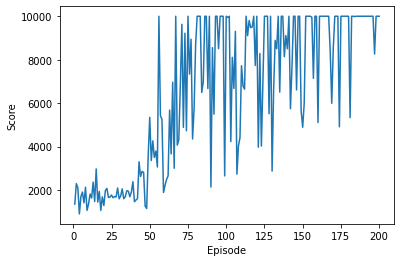

In [78]:
plt.plot(episode_array,time_score_array)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [79]:
def normalize_scores(score_input):
  data = np.copy(score_input)
  normalizing_factor = np.amax(score_input)
  print(data[0]/np.amax(score_input))
  print(normalizing_factor)
  normed = []
  for score in range(len(data)):
    print(data[score]/np.amax(score_input))
    normed.append(data[score]/np.amax(score_input))
    #print(normed)
  return normed

normalized_time_scores = normalize_scores(time_score_array)
print(normalized_time_scores)
print(normalized_time_scores[0])


0.1349134913491349
9999
0.1349134913491349
0.22932293229322934
0.21052105210521052
0.08990899089908991
0.1699169916991699
0.19041904190419043
0.1409140914091409
0.21272127212721273
0.10601060106010601
0.13561356135613561
0.18151815181518152
0.1633163316331633
0.23612361236123613
0.1471147114711471
0.297029702970297
0.14441444144414442
0.1938193819381938
0.10591059105910591
0.16841684168416843
0.12831283128312831
0.19771977197719773
0.2073207320732073
0.16541654165416542
0.16751675167516752
0.1769176917691769
0.1644164416441644
0.1698169816981698
0.16781678167816783
0.20932093209320932
0.15951595159515952
0.17241724172417242
0.20502050205020503
0.16001600160016002
0.16901690169016903
0.19671967196719672
0.19491949194919492
0.16871687168716873
0.19061906190619063
0.23832383238323832
0.14601460146014603
0.15391539153915393
0.16041604160416043
0.32993299329932996
0.26222622262226225
0.2861286128612861
0.28072807280728074
0.126012601260126
0.11461146114611462
0.35853585358535855
0.534453445

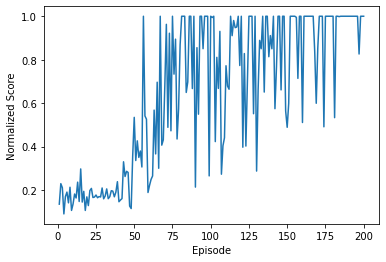

In [80]:
plt.plot(episode_array, normalized_time_scores)
plt.ylabel('Normalized Score')
plt.xlabel('Episode')
plt.show()

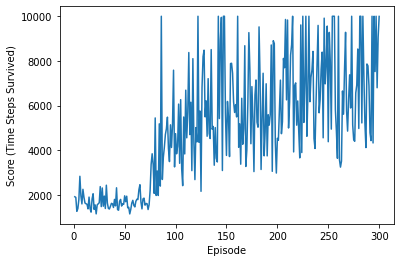

In [125]:
plt.plot(episode_array,time_score_array, scaley=True)
plt.ylabel('Score (Time Steps Survived)')
plt.xlabel('Episode')
plt.show()

In [29]:
from sklearn import preprocessing
import numpy as np

data = np.copy(time_score_array)
print("Data = ", data)

# normalize the data attributes
normalized = preprocessing.normalize(data)
print("Normalized Data = ", normalized)

Data =  [1927 1665 2211 1205 1599 2246 1994 1851 1570 1666 1630 1052 2332 1374
 1590 1299 1228 1667 1566 1416 1539 1726  949 1550 1672 1773 1634 1192
 1955 1232 1915 1610 1622 1353 1469 1231 1559 1326 2181 2066 2662 7703
 2042 3817 3516 3574 4409 3044 8271 4629 2795 2964 3133 1620 1283 2212
 1433 2126 1236 1358 1982 1646 2153 1558 1158 1733 1259 1116 2694 1908
 1559 1964 1689 1479 1000 1385 1473 2304 1445 1243 1397 1776 1266 1884
 1477 1607 1990 1845 2054 1183 1514 1964 1800 1691 1304 1817 1352 1548
 2173 1980 1905 1596 1188 1688 1244 1224 1358 1758 1494 1985 1699 1469
 1642 1311 1282 1426 1839 3738 5912 2429 9999 5029 2148 2035 9999 5105
 9999 7331 6585 9999 9999 8682 9999 4677 9999 9999 6835 9999 9773 3186
 9999 6454 5939 9999 2890 9676 9999 9999 9999 8467 8910 9999 9764 7972
 9999 9999 9441 1308 9999 9999 9999 5351 8263 9999 9999 9999 7222 4664
 5444 9999 3466 9999 7331 9999 9999 9999 9999 9999 9999 9999 5384 9999
 5763 9999 9999 9999 9999 9999 9999 9999 9999 7509 9999 9999 3480 139

ValueError: ignored

In [30]:
print(time_score_array[0]/np.amax(time_score_array))

0.1927192719271927


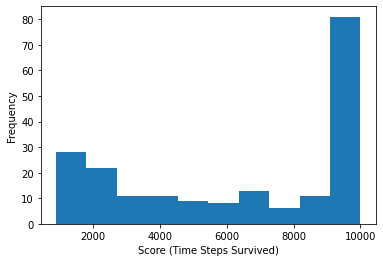

In [81]:
plt.hist(time_score_array)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

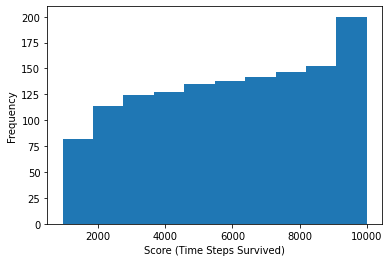

In [32]:
plt.hist(time_score_array, cumulative = True)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

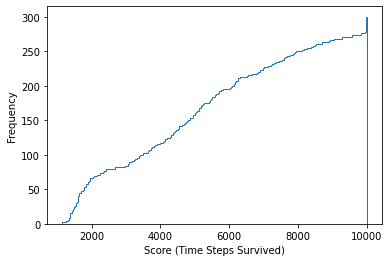

In [129]:
plt.hist(time_score_array, cumulative = True, histtype = 'step', bins=500)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

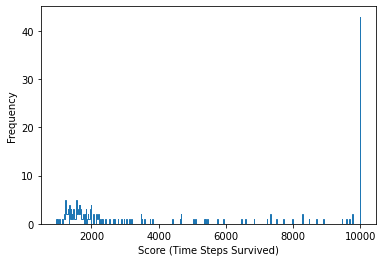

In [33]:
plt.hist(time_score_array, histtype = 'step', bins=500)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

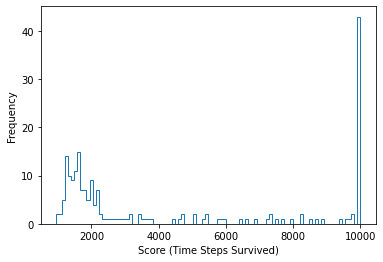

In [34]:
plt.hist(time_score_array, histtype = 'step', bins = 100)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

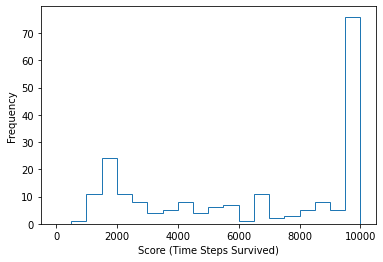

In [82]:
def bin_width(width_int, data_array):
  bin_size = []
  num_of_bins = int(round(np.amax(data_array)/width_int))
  for i in range(num_of_bins+1):
    bin_size.append(width_int*i)
  return bin_size

plt.hist(time_score_array, histtype = 'step', bins= bin_width(500, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

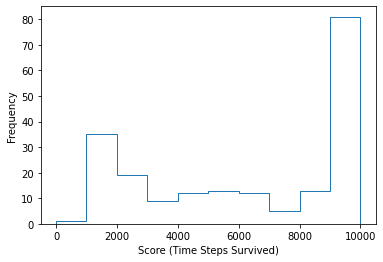

In [83]:
plt.hist(time_score_array, histtype = 'step', bins= bin_width(1000, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

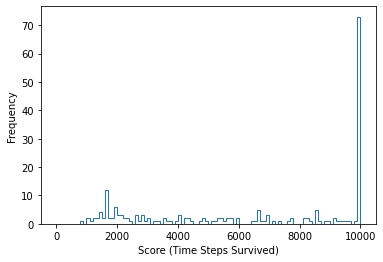

In [84]:


plt.hist(time_score_array, histtype = 'step', bins= bin_width(100, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

In [85]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 8000:
    count+=1
print(count)

print(count/n_episodes)

94
0.47


In [86]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 9000:
    count+=1
print(count)

print(count/n_episodes)

81
0.405


In [87]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 9999:
    count+=1
print(count)

print(count/n_episodes)

70
0.35
